In [1]:
import sys, os
sys.path.insert(1, '../python')
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/packages/vlasov_solver'))

In [2]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

In [27]:
# v0c_va = -0
nc_nh = 19
# v0h_va = - nc_nh * nc_nh
a_c = 1
a_h = 1
thpar_tcpar = 5
tcpar_tp = 1
beta_p = 1
mi_me = 1836
thpar_tp = tcpar_tp * thpar_tcpar
# k: kdi
# omega: w / Omega_ci
def A(k, omega, v0c_va):
    v0h_va = - v0c_va * nc_nh
    v0c_vr = v0c_va / mi_me * k / (omega / mi_me - 1)
    v0h_vr = - v0c_vr * nc_nh
    vr_wparc = (omega / mi_me - 1) / k * np.sqrt(mi_me * 1/ tcpar_tp) / np.sqrt(beta_p)
    vr_wparh = (omega / mi_me - 1) / k * np.sqrt(mi_me * 1/ thpar_tp) / np.sqrt(beta_p)
    denominator_c = np.exp(- (vr_wparc * (1 - v0c_vr))**2)
    denominator_h = (1 / nc_nh / np.sqrt(thpar_tcpar)) * np.exp(-(vr_wparh * (1 - v0h_vr))**2)
    numerator_c = ((1 - v0c_vr) * a_c - 1) * denominator_c
    numerator_h = ((1 - v0h_vr) * a_h - 1) * denominator_h
    numerator = numerator_c + numerator_h
    denominator = denominator_c + denominator_h
    result = numerator / denominator - 1 / (mi_me / omega - 1)
#     print('k={0:.2g}, vr_v0h={1:.2g}, vr_wparh={2:.2g}, result={3:.2g}'.format(k, 1/v0h_vr, vr_wparh, result))
#     return result
    return numerator / denominator 


In [28]:
def kennel_growth_rate(k, omega, nc_nh, beta_cpar, beta_hpar, v0c_vae, a_c, a_h):
    v0h_vae = - v0c_vae * nc_nh  
    vr_wparc = (omega - 1) / k / np.sqrt(beta_cpar)
    vr_wparh = (omega - 1) / k / np.sqrt(beta_hpar)
    v0c_vr = v0c_vae * k / (omega - 1)
    v0h_vr = v0h_vae * k / (omega - 1)
    
    q_c = np.exp(- (vr_wparc * (1 - v0c_vr))**2)
    q_h = np.exp(- (vr_wparh * (1 - v0h_vr))**2)
    B_c = (1 -  v0c_vr) * a_c - 1
    B_h = (1 - v0h_vr) * a_h - 1
    A_numerator = B_c * q_c + B_h / nc_nh * np.sqrt(beta_cpar / beta_hpar) * q_h
    A_denominator = (q_c + (1 / nc_nh) * np.sqrt(beta_cpar / beta_hpar) * q_h)
    eta = (1 - omega) / k / np.sqrt(np.pi) / np.sqrt(beta_cpar) * A_denominator
    if A_denominator == 0:
        A = 0
    else:
        A = A_numerator / A_denominator
    growth_rate = np.pi * (1 - omega) * eta * (A - omega / (1 - omega))
#     return growth_rate
    return growth_rate

In [29]:
nc_nh = 19
th_tc = 5
beta_0 = 1.
beta_cpar = beta_0
beta_hpar = beta_0 * th_tc
v0c_vae = -0.5 / 43
a_c = 1
a_h = 1.05

def whistler_freq(k):
    return k**2 / (1 + k**2)  
def helper(k, omega):
    return kennel_growth_rate(k, omega, nc_nh, beta_cpar, beta_hpar, v0c_vae, a_c, a_h)

In [30]:
k_arr = np.linspace(0.01, 1., 200)
omega_arr = [whistler_freq(k) for k in k_arr]
gamma_arr = [helper(k, omega) for k, omega in zip(k_arr, omega_arr)]

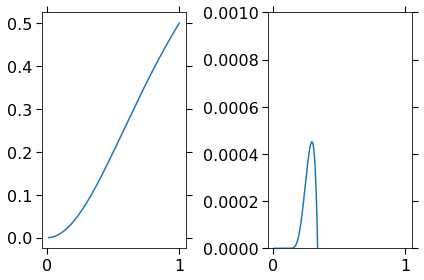

In [32]:
plt.subplot(121)
plt.plot(k_arr, omega_arr)
plt.subplot(122)
plt.plot(k_arr, np.array(gamma_arr))
plt.ylim([0, 1e-3])
plt.tight_layout()

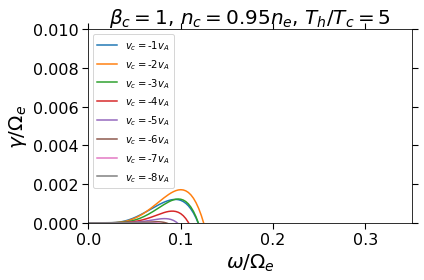

In [33]:
for v0c_va in np.linspace(-1, -8, 8):
    v0c_vae = v0c_va / 43
    def helper(k, omega):
        return kennel_growth_rate(k, omega, nc_nh, beta_cpar, beta_hpar, v0c_vae, a_c, a_h)
    gamma_arr = [helper(k, omega) for k, omega in zip(k_arr, omega_arr)]
    plt.plot(omega_arr, gamma_arr, label=f'$v_c=${v0c_va:.2g}$v_A$')
plt.title(r'$\beta_c=$' + f'{beta_cpar:.2g}, $n_c=${nc_nh/(nc_nh + 1):.2g}$n_e$, $T_h/T_c=${th_tc:.2g}')
plt.ylim([-1e-5, 1e-2])
plt.xlim([0, 0.35])
plt.xlabel(r'$\omega/\Omega_e$')
plt.ylabel(r'$\gamma/\Omega_e$')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('figure/whistler_hfi_ivan_cmp_beta_03.png', dpi=100)

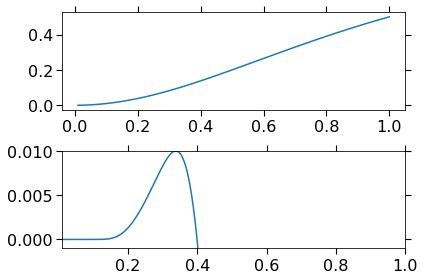

In [254]:
plt.subplot(211)
plt.plot(k_arr, omega_arr)

plt.subplot(212)
plt.plot(k_arr, gamma_arr)
plt.ylim([-1e-3, 1e-2])

plt.xlim([1e-2, 1])
plt.tight_layout()

In [352]:
def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

def fast_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

theta = 0
beta_0 = .9
aol = 37 / 3e5
tc_tp = 1.
th_tc = 3.6

t_list=[1., tc_tp, tc_tp * th_tc]
a_list=[1., 1.09, 1.05]
n_list=[1.,.81, .19] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v0c = -1.5
v_list=[0., v0c, -v0c * n_list[1] / n_list[2]]
n = 10
method = 'numpy'

kdi = 1

target_kde = 1
target_kdi = target_kde * np.sqrt(1836)
target_k = kdi_2_krhoi(target_kdi, beta_0)

k = kdi_2_krhoi(kdi, beta_0)
kz, kp = kzkp(k, theta)

param = [kz, kp, beta_0, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]



In [353]:
6 / 32

0.1875

In [354]:
# 21.8 * 6 / np.sqrt(8.7)

In [355]:
seed_freq = fast_freq(k, theta, beta_0)
freq = follow_k(seed_freq, target_k, param,
                log_incrmt = 0.01, incrmt_method = 'log')


In [356]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2) /np.sqrt(1836) / np.sqrt(beta_0)
kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(freq[-1]))

(0, 0.2)

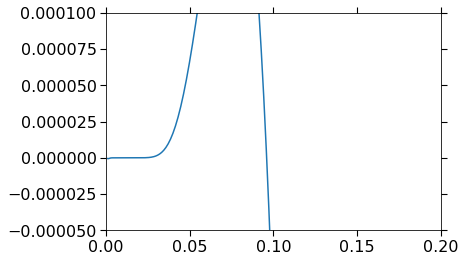

In [357]:
# plt.plot(kde_list, np.array(freq[-1]).real/1836)
# plt.plot(kde_list, np.array(freq[-1]).imag/1836)
plt.plot(np.array(freq[-1]).real/1836, np.array(freq[-1]).imag/1836)
plt.ylim([-5e-5, 1e-4])
plt.xlim([0, 0.2])
# plt.xlim([0, 0.1])

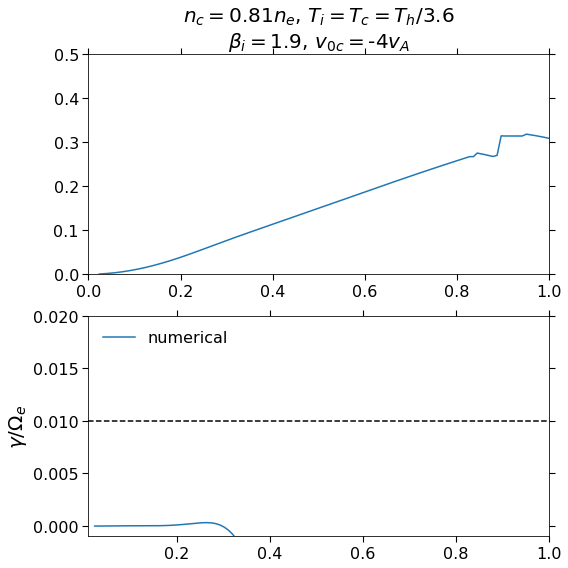

In [293]:
plt.figure(figsize=[8, 8])
plt.subplot(211)
# plt.plot(k_arr, omega_arr)
plt.plot(kde_list, np.array(freq[-1]).real / 1836, '-', markersize=1)
title = f'$n_c={n_list[1]}n_e$, $T_i=T_c=T_h/{t_list[2]}$\n'
title += r'$\beta_i=$' + f'{beta_0:.2g}, ' + r'$v_{0c}=$' + f'{v_list[1]}$v_A$'
plt.title(title)
plt.xlim([0, 1.0])
plt.ylim([0, 0.5])

plt.subplot(212)
# plt.plot(k_arr, gamma_arr, label='Kennel')
plt.plot(kde_list, np.array(freq[-1]).imag / 1836, label='numerical')
plt.ylim([-1e-3, 2e-2])
plt.xlim([0, 1.0])
plt.ylabel(r'$\gamma/\Omega_{e}$')
plt.axhline(1e-2, linestyle='dashed', color='k')
plt.legend(loc='upper left', frameon=False, fontsize=16)

plt.xlim([1e-2, 1])
plt.tight_layout()
# plt.savefig('figure/whistlers_with_large_growth_rate.png', dpi=100)

In [47]:
v0c_va = v_list[1]
nc_nh = n_list[1] /n_list[2]
beta_cpar = beta_0 * t_list[1]
beta_hpar = beta_0 * t_list[2]
v0c_vae = v0c_va / 43
a_c = a_list[1]
a_h = a_list[2]
def helper(k, omega):
    return kennel_growth_rate(k, omega, nc_nh, beta_cpar, beta_hpar, v0c_vae, a_c, a_h)
omega_arr = np.array(freq[-1]).real / 1836
gamma_arr = [helper(k, omega) for k, omega in zip(kde_list, omega_arr)]

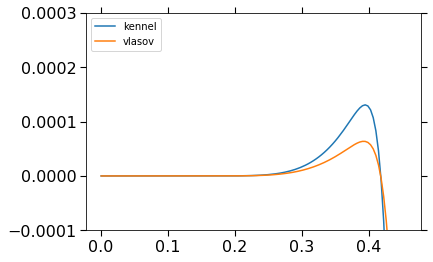

In [54]:
plt.plot(omega_arr, gamma_arr, label=f'kennel')
plt.plot(omega_arr, np.array(freq[-1]).imag/1836, label='vlasov')
plt.ylim([-1e-4, 3e-4])
plt.legend(loc='upper left')

In [361]:
a = [1, 2, 4, 7, 8]

In [362]:
a[1:3].reverse()

In [363]:
a

[1, 2, 4, 7, 8]